## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
# knn imputer
from sklearn.impute import KNNImputer

In [2]:
data = pd.read_excel('./data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

## Exploratory Data Analysis

### Univariate analysis

In [ ]:
data

In [3]:
data.head(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


On first overview of the data:
- Categorical variables are mostly one-hot encoded already. The exception is `AGE_PERCENTIL` and `WINDOW`. 
- The numeric variables are min-max scaled.
- There are 384 unique people identifiers.
- There are 5 missing values from disease groupings.
- Blood metrics have 1104 common missing values.
- Other biometrics have various missing values ranging from 685 to 748
- There are no missing values for `PATIENT_VISIT_IDENTIFIER`, `AGE_ABOVE65`, `AGE_PERCENTIL`, `GENDER`, `WINDOW`, and `ICU` (the target)


<AxesSubplot: >

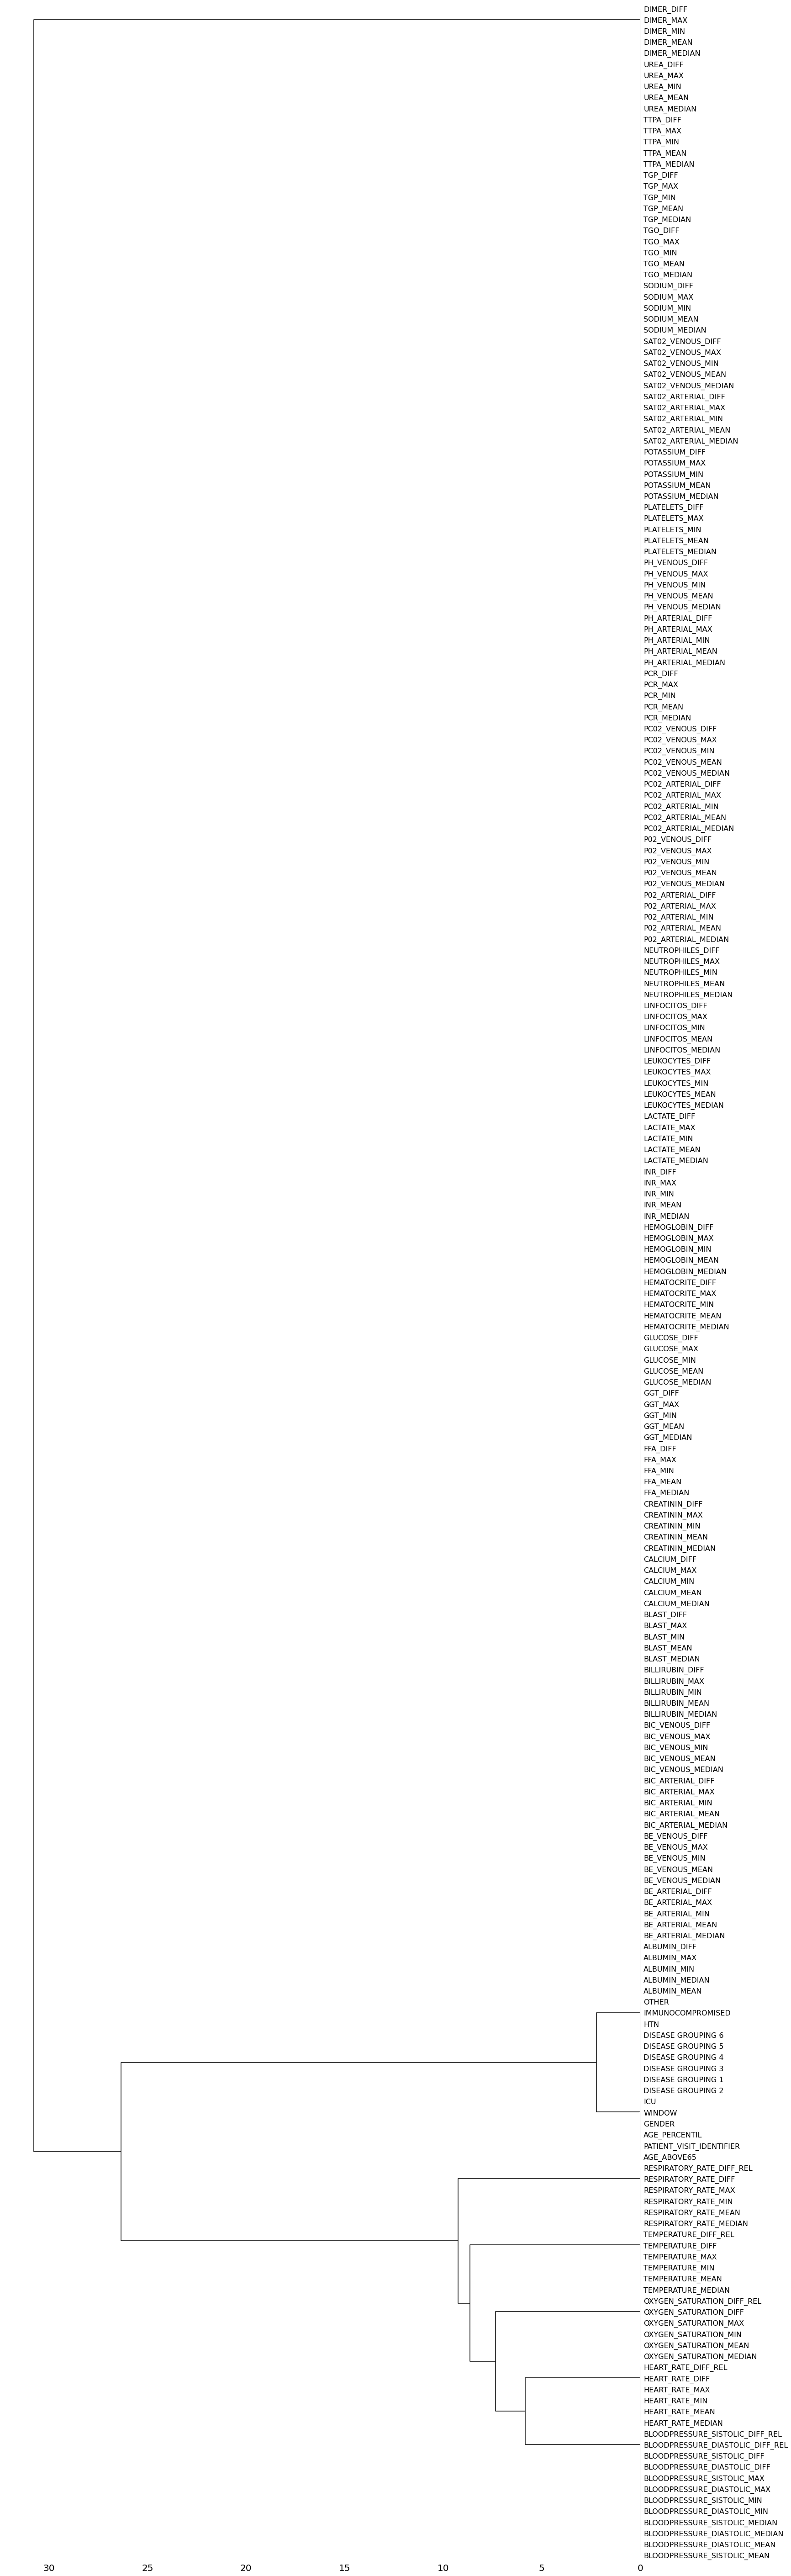

In [7]:
msno.dendrogram(data)

#### Target feature

The data maintainers indicated that time windows leading up to ICU care, not during or after ICU care, should be used during modeling.

Each person has 5 rows, a row for each `WINDOW` time.

##### Distribution plots

<AxesSubplot: xlabel='PATIENT_VISIT_IDENTIFIER', ylabel='Count'>

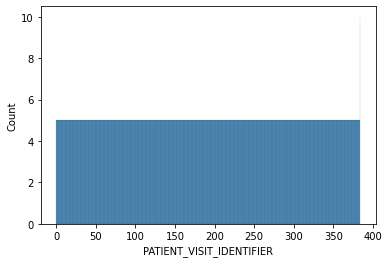

In [38]:
sns.histplot(data, x='PATIENT_VISIT_IDENTIFIER', binwidth=1)

There are three possibilities for ICU care:
- the person was admitted straight to ICU (`1_1`, see the bar graph below)
- the person was transported to ICU (`2_1`)
- the person was never in ICU (`1_0`)

In [18]:
target_df = data[['PATIENT_VISIT_IDENTIFIER', 'ICU']].groupby('PATIENT_VISIT_IDENTIFIER').nunique().rename(columns={'ICU': 'loc'}).merge(
    data[data['WINDOW'] == '0-2'][['PATIENT_VISIT_IDENTIFIER', 'ICU']].rename(columns={'ICU': 'Init'}),
    on='PATIENT_VISIT_IDENTIFIER'
)

target_df = target_df.assign(
    lab = target_df['loc'].astype(str) + '_' + target_df['Init'].astype(str),
)

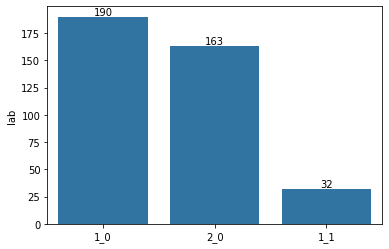

In [39]:
plot = sns.barplot(data=target_df['lab'].value_counts())

plot.bar_label(plot.containers[0]);

There are about 30 people that went straight to ICU. 
This data cannot be used in the modeling.

There are ~180 people that never went to ICU care.
These are the negative values for modeling.

There are ~160 people that transitioned to ICU care.
These are the positive values for modeling.

While the remaining people are somewhat balanced (180 to 160), we will have 5 time window values for the negatives (180x5 values [900]) and intermediate windows for the positives (ranging from 1x160 to 4x160 values [160-640]). 
That means the target is imbalanced towards negative values.
This might result in default models making better predictions for negative cases.
I think random undersampling of the negative values would be a good approach to handle the imbalance.

When were people transported to ICU?

In [33]:
window_counts = target_df[target_df['lab'] == '2_0'][['PATIENT_VISIT_IDENTIFIER', 'lab']]\
    .merge(
        data[['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']],
        on='PATIENT_VISIT_IDENTIFIER'
    )\
    .drop(columns=['PATIENT_VISIT_IDENTIFIER', 'lab'])\
    .groupby('WINDOW')\
    .sum()

window_counts = window_counts.reset_index()

In [ ]:
window_counts['ICU'].iloc[0] = 32

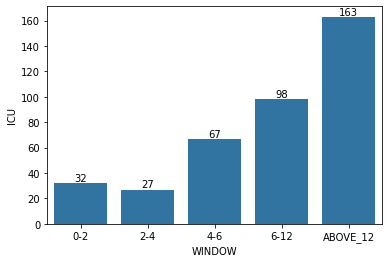

In [41]:
plot = sns.barplot(data=window_counts, x='WINDOW', y='ICU')
plot.bar_label(plot.containers[0]);

Most people were moved to ICU after 12 hrs in the hospital.

##### Modeling decision: recode the target

In [19]:
data2 = data.copy()

data2 = data2[data2['ICU'] != 1]

data2 = data2.merge(
    target_df[['PATIENT_VISIT_IDENTIFIER', 'lab']],
    on='PATIENT_VISIT_IDENTIFIER'
).rename(columns={'lab': 'target'})

data2['target'] = np.where(data2['target'] == '1_0', 0, 1)
data2.drop(columns=['WINDOW', 'ICU'], inplace=True)

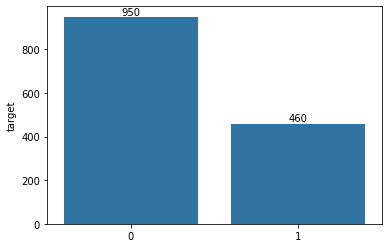

In [44]:
plot = sns.barplot(data=data2['target'].value_counts())
plot.bar_label(plot.containers[0]);

The target values for modelling have 950 negatives and 460 positives.

#### Numeric features

In [21]:
# names of numeric features for plotting
num_data = data[data.columns[data.nunique() > 2]]
num_data = num_data[num_data.columns[num_data.dtypes != 'O']]
num_cols = num_data.columns
del num_data

##### Distribution plots

The data is reporting multiple stat features per unique measurement. 
I want to explore the relevance of those stat types for "information gain"* wrt the measurement.
- *does the choice of stat change the overall distribution for the measurement?

I will use this information later to remove redundant features.

In [22]:
unique_names = pd.Series(list(set(['_'.join(x[:-1]) for x in num_cols.str.split(pat='[_]')[1:]])))
unique_names[~unique_names.str.contains('DIFF')]

biometrics = pd.Series([x[:-5] for x in unique_names[unique_names.str.contains('DIFF')]])

biomarkers = pd.merge(
    unique_names[~unique_names.str.contains('DIFF')].rename('name'), 
    biometrics.rename('name'), 
    how='outer', 
    indicator=True
    )
biomarkers = biomarkers[biomarkers['_merge'] == 'left_only'].drop(columns='_merge')

Separating numeric features by measurement type, blood biomarker or vital biometric.

In [6]:
biomarkers_df = pd.DataFrame()

for i in biomarkers['name']:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    biomarkers_df = pd.concat([biomarkers_df, subs_df], axis=1)

In [7]:
biometrics_df = pd.DataFrame()

for i in biometrics:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    biometrics_df = pd.concat([biometrics_df, subs_df], axis=1)

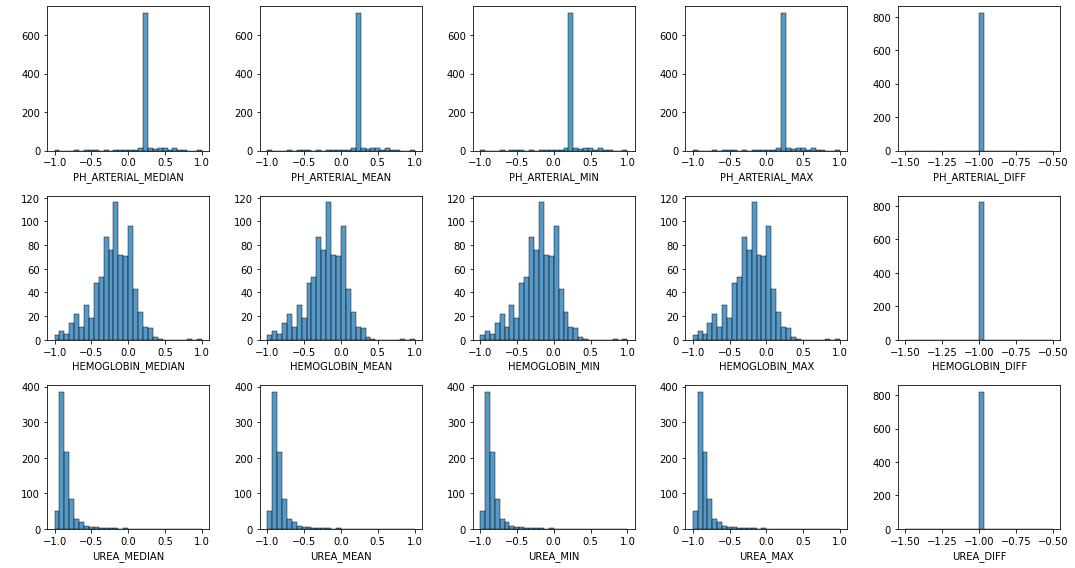

In [181]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8))

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=biomarkers_df, x=biomarkers_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

In [81]:
diff_df = biomarkers_df[biomarkers_df.columns[biomarkers_df.columns.str.contains('DIFF')]]

np.alltrue([diff_df[x].value_counts().count() < 2 for x in diff_df.columns])

True

`DIFF` features do not have parameter space, all values are the same (-1). 
I think that is because there are no repeated measures for these features.
`MEDIAN`, `MEAN`, `MIN`, and `MAX` appear to have the same information. 
We can just focus on one stat per measurement for an overview of distributions.

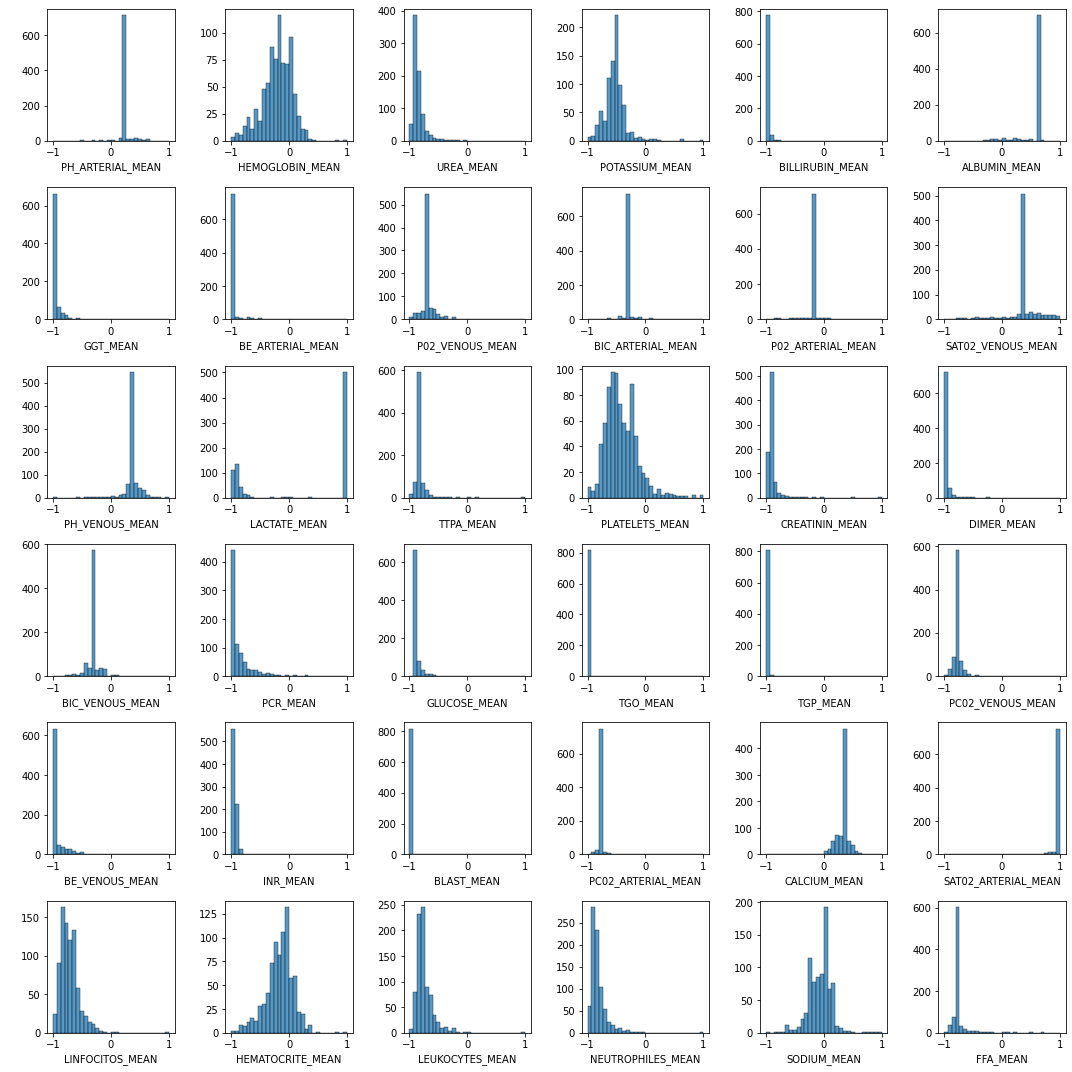

In [183]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

mean_biomar_df = biomarkers_df[biomarkers_df.columns[biomarkers_df.columns.str.contains('MEAN')]]

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=mean_biomar_df, x=mean_biomar_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The distributions are scaled (-1, 1) but not zero centered. 
`HEMOGLOBIN`, `POTASSIUM`, `PLATELETS`, `LINFOCITOS`, `HEMATOCRITE`, `LEUKOCYTES`, `NEUTROPHILES`, and `SODIUM` are more distributed in parameter space and would have less kurtosis compared to the other distributions that have strong peaks. 
`LACTATE` values look bimodal. `HEMATOCRITE`, `SODIUM`, and `HEMOGLOBIN` appear gaussian. 
The other named distributions have a right skew to positive values.

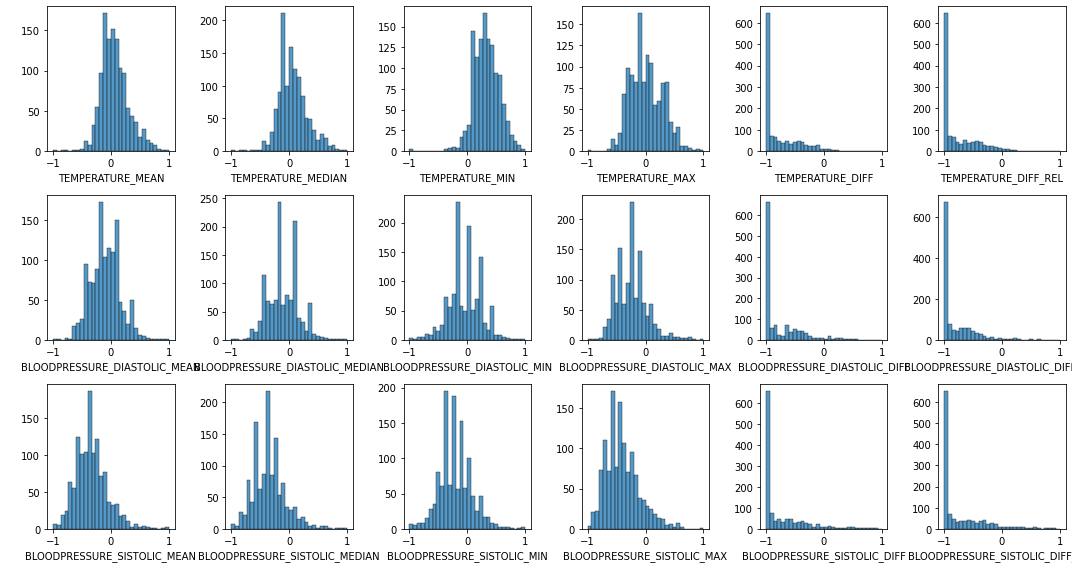

In [187]:
fig, axes = plt.subplots(3, 6, figsize=(15, 8))

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=biometrics_df, x=biometrics_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The biometric data distributions are slightly different moving from `MEAN`, `MEDIAN`, `MIN`, `MAX`, `DIFF`, and `DIFF_REL`.
`DIFF` and `DIFF_REL` look like they would be highly correlated. 
The `DIFF` measures will be interesting to explore more because they represent change in a person's condition over the time window. 
For modeling, we may use one stat from `MEAN`, `MEDIAN`, `MIN`, `MAX` and a then one of the `DIFF` stats to reduce collinearity.

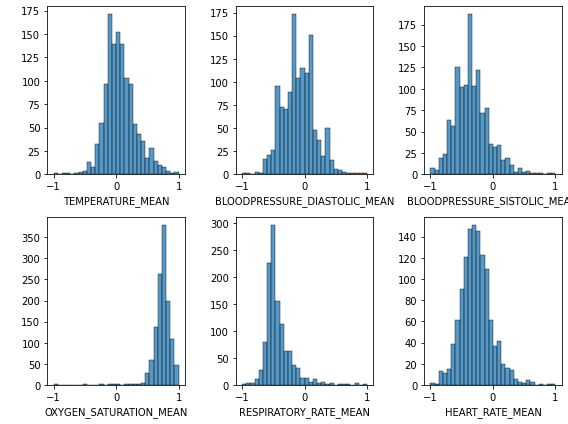

In [190]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

mean_biomet_df = biometrics_df[biometrics_df.columns[biometrics_df.columns.str.contains('MEAN')]]

for i in range(0, axes.flatten().shape[0]):
    sns.histplot(data=mean_biomet_df, x=mean_biomet_df.columns[i], bins=30, ax=axes.flatten()[i])
    axes.flatten()[i].set_ylabel(' ')

plt.tight_layout()

The biometric features are mostly gaussian and appear to have a typical kurtosis (no peaking behavior).
`OXYGEN_SATURATION` is skewed left to negative values and `RESPIRATORY_RATE` is skewed right to positive values.

The overall pattern of differences between biomarker and biometric data is consistent with the description of these features; biometric data can be collected on more occaisions than blood biomarker data. Those differences include:
- more missing values in the biomarker data
  - the data maintainers suggest to use a backfill/forward fill method to fill in the blanks. It's likely a safe assumption as they point out that the feature measures are the same for the intermediate time windows.
- less variance in the statistic features of biomarker data
  - the variance comes from summarizing over the repeated measures and biometric data has multiple repeated measures

##### Modeling decision: missing value imputation
I will use a forward fill for fill from the first to the next measure and then a backward fill to fill the first measure to earlier, unmeasured time windows.

In [23]:
numerics = pd.concat([biomarkers, pd.DataFrame({'name': biometrics})], axis=0)

In [24]:
numerics_df = pd.DataFrame()

for i in numerics['name']:
    subs_df = data[data.columns[data.columns.str.contains(i)]]
    numerics_df = pd.concat([numerics_df, subs_df], axis=1)

In [25]:
impute_numerics = numerics_df.merge(
    data['PATIENT_VISIT_IDENTIFIER'],
    left_index=True,
    right_index=True
).groupby('PATIENT_VISIT_IDENTIFIER')\
.ffill()\
.bfill() 

In [37]:
[x not in impute_numerics.columns for x in data.columns]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fals

In [44]:
cols = [x not in impute_numerics.columns for x in data.columns]

data3 = data[data.columns[cols]]\
    .merge(
        impute_numerics,
        left_index=True,
        right_index=True
    )

#### Categorical features

In [47]:
cat_cols = []

for i in data.columns:
    if i not in num_cols:
        cat_cols.append(i)

cat_cols = pd.Series(cat_cols)

cat_cols = cat_cols[~cat_cols.str.contains('DIFF')]

Are disease groupings mutually exclusive? Can group membership span multiple disease groups?

In [64]:
disease_df = data\
    [['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3','DISEASE GROUPING 4', 'DISEASE GROUPING 5']]\
    .assign(
        total = data['DISEASE GROUPING 1'] + data['DISEASE GROUPING 2'] + data['DISEASE GROUPING 3'] + data['DISEASE GROUPING 4'] + data['DISEASE GROUPING 5']
    ).merge(
        data['PATIENT_VISIT_IDENTIFIER'],
        left_index=True,
        right_index=True
    ).groupby('PATIENT_VISIT_IDENTIFIER')\
    .head(1)

In [62]:
disease_df[disease_df['total'] > 1].head(5)

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,total,PATIENT_VISIT_IDENTIFIER
145,0.0,0.0,1.0,1.0,1.0,3.0,29
170,0.0,0.0,1.0,0.0,1.0,2.0,34
220,0.0,0.0,1.0,1.0,0.0,2.0,44
315,0.0,1.0,0.0,1.0,0.0,2.0,63
385,0.0,0.0,1.0,0.0,1.0,2.0,77


In [72]:
data[data['PATIENT_VISIT_IDENTIFIER'] == disease_df[disease_df['total'] > 1].head(1)['PATIENT_VISIT_IDENTIFIER'].values[0]]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
145,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
146,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,NaN,-1.000000,NaN,NaN,-1.000000,-1.000000,NaN,-1.000000,2-4,0
147,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
148,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-0.714286,-1.000000,-0.804348,-0.796421,-0.895824,-0.738863,-0.724924,-1.000000,6-12,1
149,29,1,70th,0,0.0,0.0,1.0,1.0,1.0,0.0,...,-0.214286,-0.838384,-0.561437,-0.324974,-0.374046,-0.232258,-0.214286,-0.840206,ABOVE_12,1


The disease groupings are not mutually exclusive. 
I was considering a pie chart for the disease groups but I think bar charts will work for the distribution overview.

##### Distribution plots

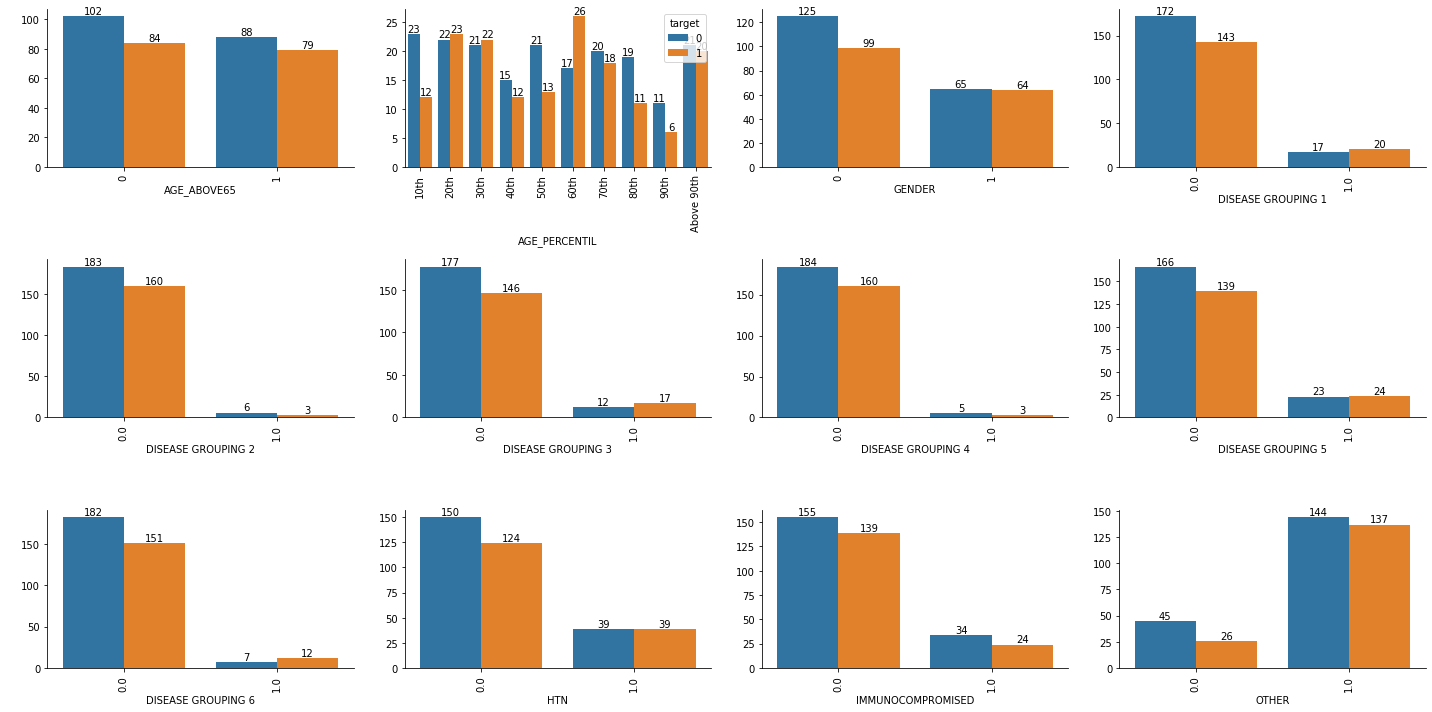

In [65]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

cat_df = data[cat_cols]\
    .merge(
        data2[['PATIENT_VISIT_IDENTIFIER', 'target']],
        left_index=True,
        right_index=True
    )\
    .groupby('PATIENT_VISIT_IDENTIFIER')\
    .head(1)\
    .drop(columns=['WINDOW', 'ICU'])

for i in range(0, axes.flatten().shape[0]):
    if cat_df.columns[i] == 'AGE_PERCENTIL':
        sns.barplot(
            data=pd.DataFrame(cat_df.groupby('target')[cat_df.columns[i]].value_counts()).rename(columns={cat_df.columns[i]: 'count'}).reset_index(), 
            x=cat_df.columns[i],
            y='count',
            hue='target',
            ax=axes.flatten()[i],
            order=['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', 'Above 90th']
        )
        axes.flatten()[i].tick_params(axis='x', labelrotation=90)
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[0])
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[1])
        axes.flatten()[i].set_ylabel(' ')
        sns.despine()
    else:
        sns.barplot(
            data=pd.DataFrame(cat_df.groupby('target')[cat_df.columns[i]].value_counts()).rename(columns={cat_df.columns[i]: 'count'}).reset_index(), 
            x=cat_df.columns[i],
            y='count',
            hue='target',
            ax=axes.flatten()[i]
        )
        axes.flatten()[i].tick_params(axis='x', labelrotation=90)
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[0])
        axes.flatten()[i].bar_label(axes.flatten()[i].containers[1])
        axes.flatten()[i].get_legend().remove()
        axes.flatten()[i].set_ylabel(' ')
        sns.despine()

plt.tight_layout()

These are distribution plots of the people who comprise the dataset.
The `DISEASE GROUPING` features are heavily imbalanced to be absent in people.
`HTN` and `IMUNOCOMPROMISED` are also moslty absent in the people of the dataset.
However, `OTHER` is mostly present.
Moving across groups, the `target` values are somewhat balanced.
However, `target` values are imbalanced for some groups in `AGE_PERCENTIL`:
- there are more negatives in `10th`, `50th`, and `90th`
- there are more positives in `60th`

We need to recode the `AGE_PERCENTIL` feature.

##### Modeling decision: one-hot encoding age groups

In [45]:
age = data['AGE_PERCENTIL']\
    .map({
        '10th': 1,
        '20th': 2,
        '30th': 3,
        '40th': 4,
        '50th': 5,
        '60th': 6,
        '70th': 7,
        '80th': 8,
        '90th': 9,
        'Above 90th': 10
    })

age_df = pd.DataFrame(age).rename(columns={'AGE_PERCENTIL': 'age_group'})

data3 = data3\
    .merge(
        pd.get_dummies(age_df, columns=['age_group'], drop_first=True),
        left_index=True,
        right_index=True
    )\
    .drop(columns=['AGE_PERCENTIL'])

There are 5 missing values for the `DISEASE GROUPing`, `HTN`, `IMMUNOCOMPROMISED`, `OTHER` features.
We can impute them with knn imputer.

In [58]:
data3[data3['DISEASE GROUPING 1'].isna()]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF_REL,age_group_2,age_group_3,age_group_4,age_group_5,age_group_6,age_group_7,age_group_8,age_group_9,age_group_10
995,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
996,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
997,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
998,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
999,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0


These missing values are from a single person.

In [49]:
imputer = KNNImputer(n_neighbors=3)

impute_df = pd.DataFrame(
    imputer.fit_transform(data3.drop(columns='WINDOW')), 
    columns=data3.drop(columns='WINDOW').columns
)

In [62]:
p199 = impute_df[data3['DISEASE GROUPING 1'].isna()].head(6)
p199

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF_REL,age_group_2,age_group_3,age_group_4,age_group_5,age_group_6,age_group_7,age_group_8,age_group_9,age_group_10
995,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The values this person ended up with were negative (0) for all actegories but positive (1) for `OTHER`.

Finally, we can recode the target feature for the `WINDOW` features to include in multivariate EDA and modeling.

In [73]:
data4 = impute_df.copy()

data4 = data4\
    .merge(
        data3[['WINDOW']],
        left_index=True,
        right_index=True
    )

data4 = data4[data4['ICU'] != 1]

data4 = data4.merge(
    target_df[['PATIENT_VISIT_IDENTIFIER', 'lab']],
    on='PATIENT_VISIT_IDENTIFIER'
).rename(columns={'lab': 'target'})

data4['target'] = np.where(data4['target'] == '1_0', 0, 1)
data4.drop(columns=['WINDOW', 'ICU'], inplace=True)

In [74]:
data4.to_csv('./data/data4.csv')

### Multivariate and collinearity analysis

I have already decided that all of the stat columns should not be used for modeling.
But we can get a view of the collinearity if we leave in all the features.

In [2]:
data = pd.read_csv('./data/data4.csv').drop(columns='Unnamed: 0')